In [1]:
from iminuit import Minuit, cost
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import tiling_disk_plots as tdp
import tiling_disk_utils as tdu
import tiling_disk_optim as optim
from scipy.stats import median_abs_deviation as mad_func
mad_str = 'median_abs_deviation'
from astropy.stats import knuth_bin_width

#? one Hexagon has 4 rings of points. 1 is the most inner one, 4 is the most outer
ring_1 = [1, 36, 19, 18]
ring_2 = [2,3,4,33,34,35,20,21,22,15,16,17]
ring_3 = [9,8,7,6,5, 32,31,30,29,28,
          27,26,25,24,23, 14,13,12,11,10]
ring_4 = list(range(37, 61, 1))
rings = [ring_1, ring_2, ring_3, ring_4]

# Old Vac Comperissont code with fits

In [2]:
def import_measurement(folder, filename): 
    from tiling_disk_utils import read_txt_files
    return read_txt_files(folder)[filename]

table_raw_data = import_measurement('SteelScan_Test1', '210921_Table.txt')
table_novac_lao = import_measurement('SteelScan_Test1', '230921_LaoAll_NoVac.txt')
table_novac_lao = table_novac_lao.query('hex_nr == 1')

folder = 'Vac_Test'
meas_files = tdu.read_txt_files(folder)

#meas_files = {key: tdu.z_diff_raw_data(val, table_raw_data) for key, val in meas_files.items()}
meas_files = {key: tdu.z_diff_raw_data(val, table_novac_lao) for key, val in meas_files.items()}

# Steel_NoVac_raw_data = meas_files['210921_SteelAll_NoVac.txt']
# c_Steel_NoVac_raw = tdu.z_diff_raw_data(Steel_NoVac_raw_data, table_raw_data)

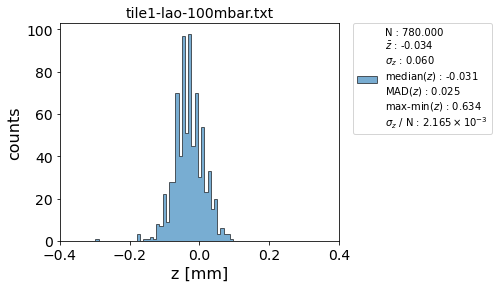

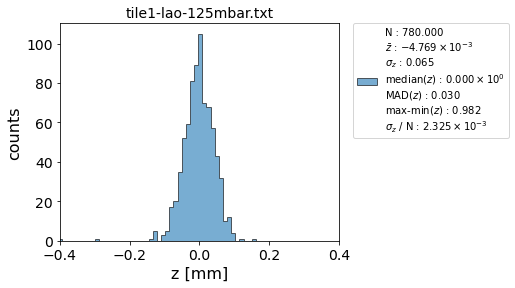

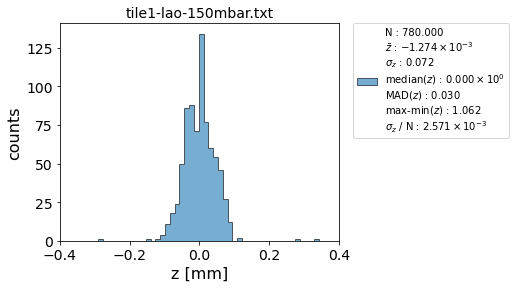

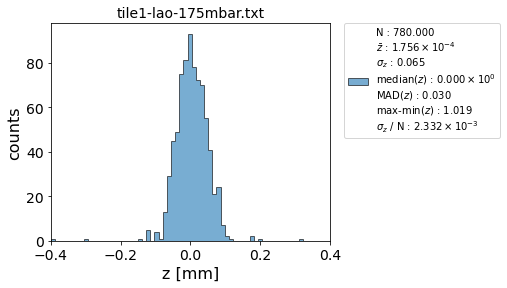

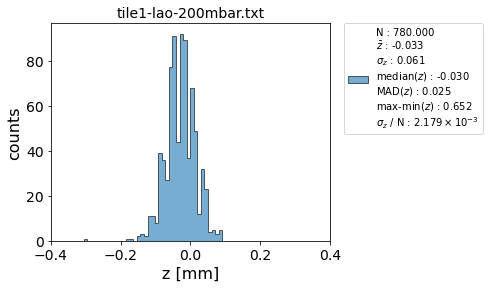

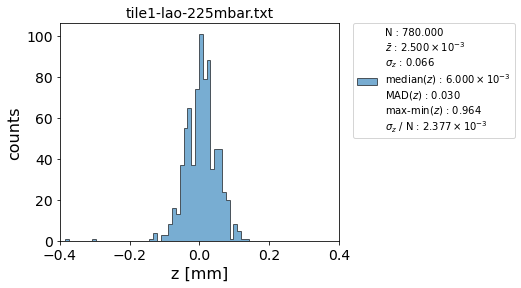

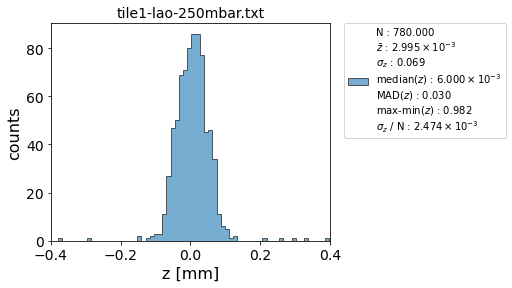

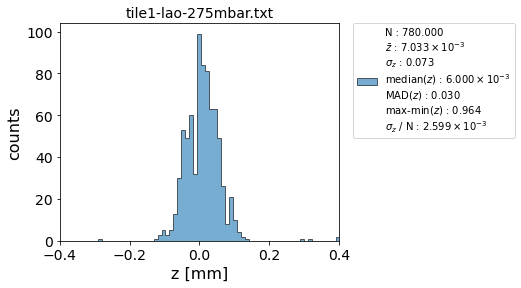

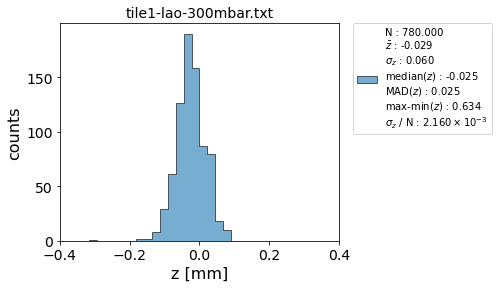

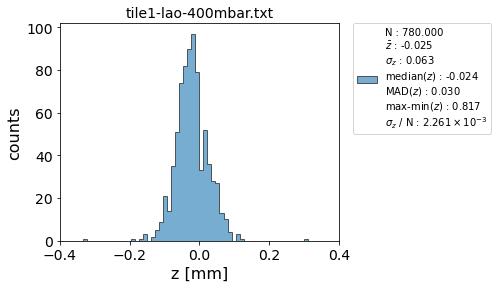

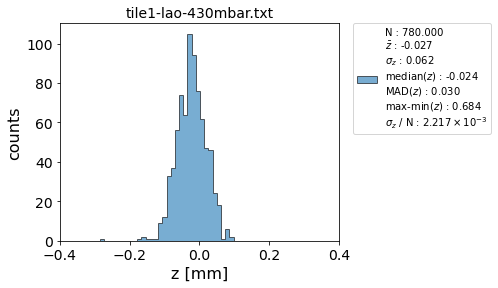

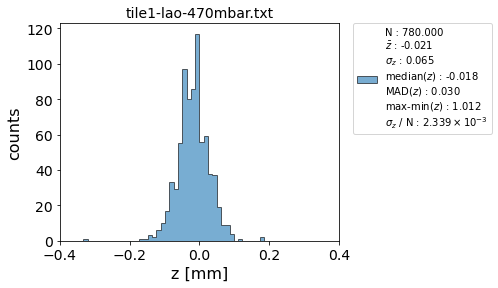

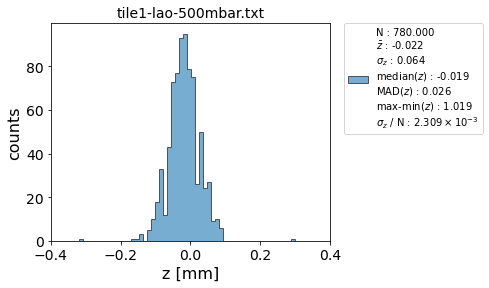

In [3]:
for key, val in meas_files.items():
    _,bins = knuth_bin_width(val['z'], return_bins=True)
    _,label = tdp.hist_label_data(val['z'])
    tdp.simple_hist(val['z'], ax=None, ylog=False, nbins=bins,
            title=key, label=label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlim(-0.4,0.4)



In [4]:
pt_data = {key: tdu.point_table(val) for key,val in meas_files.items()}

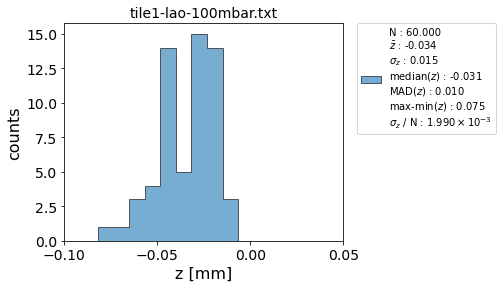

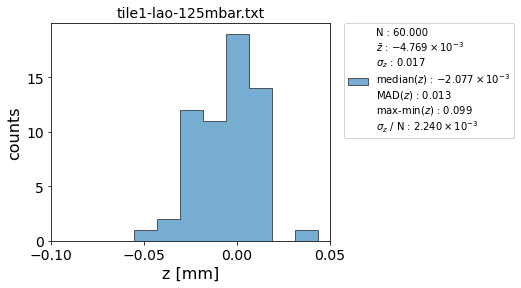

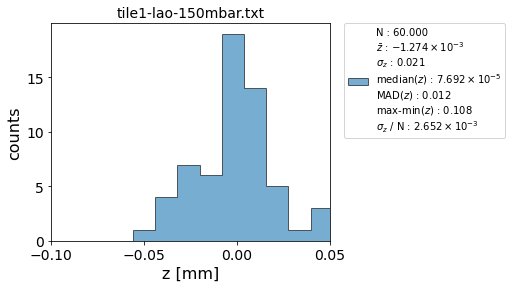

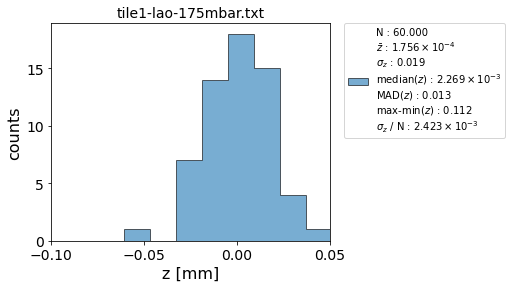

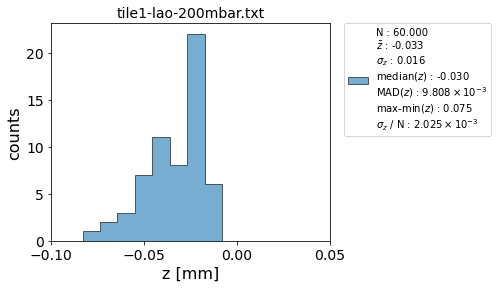

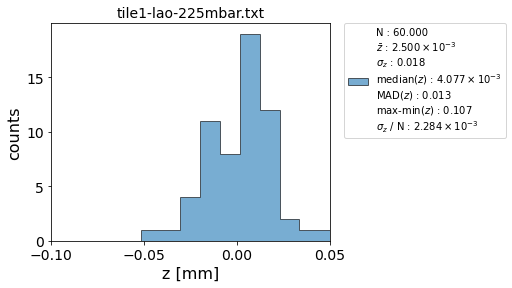

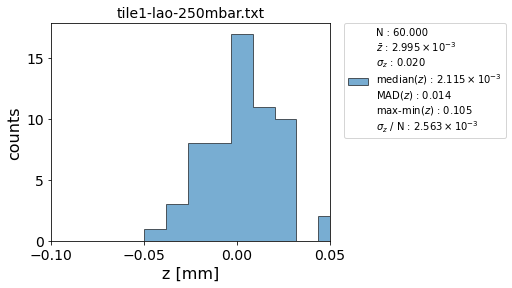

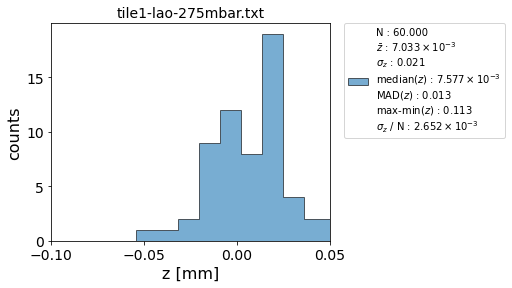

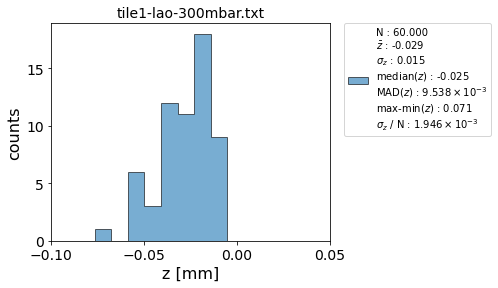

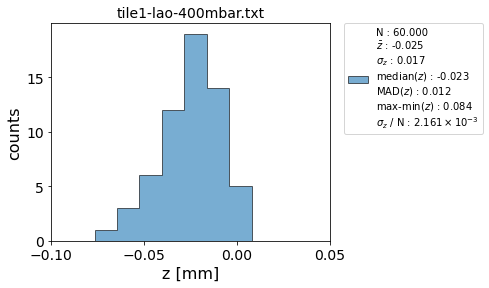

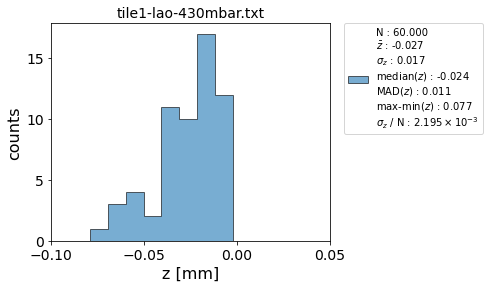

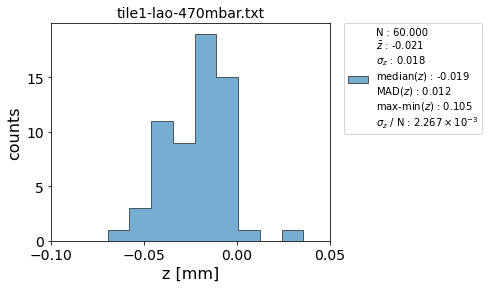

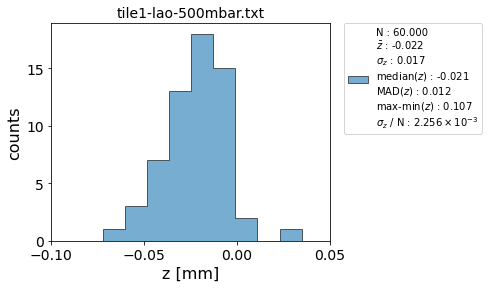

In [5]:
for key, val in pt_data.items():
    data = val['z', 'mean']
    _,bins = knuth_bin_width(data, return_bins=True)
    _,label = tdp.hist_label_data(data)
    tdp.simple_hist(data, ax=None, ylog=False, nbins=bins,
            title=key, label=label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlim(-0.1,0.05)


In [6]:
key = pt_data.keys()
key = list(key)
key = key[1]
key.split('-')[2].split('.')[0]

'125mbar'

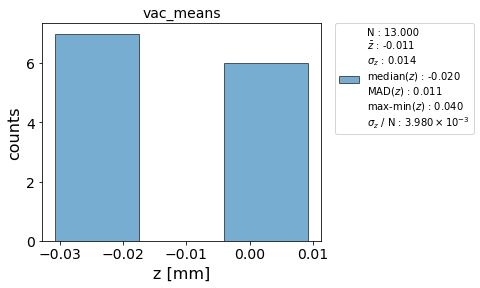

In [7]:
vac_means = {}
for key,val in pt_data.items(): 
    mean = np.mean(val['z','median'])

    nk = key.split('-')[2].split('.')[0]
    vac_means[nk] = mean
vac_means

data = list(vac_means.values())
_,bins = knuth_bin_width(data, return_bins=True)
_,label = tdp.hist_label_data(data)
tdp.simple_hist(data, ax=None, ylog=False, nbins=bins,
        title='vac_means', label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


### fits

C:\Users\Domin\AppData\Local\Temp/ipykernel_8032/3713077751.py:8: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()


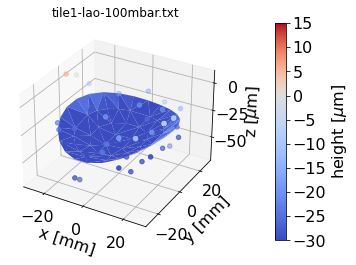

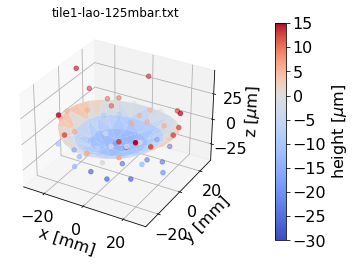

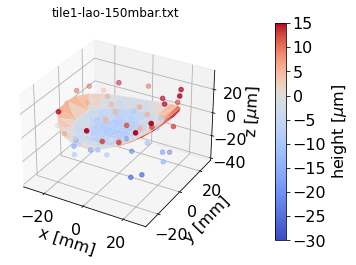

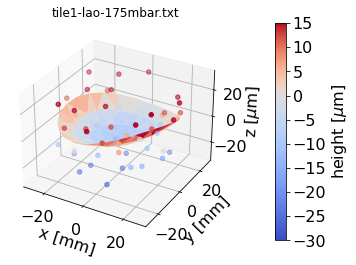

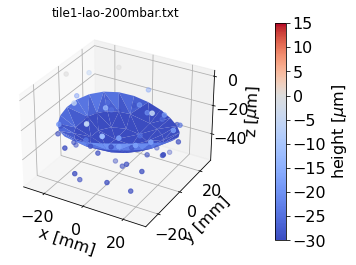

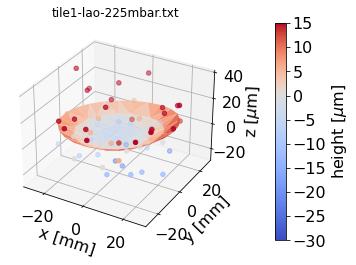

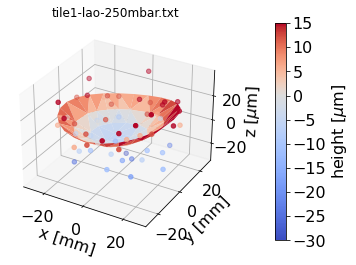

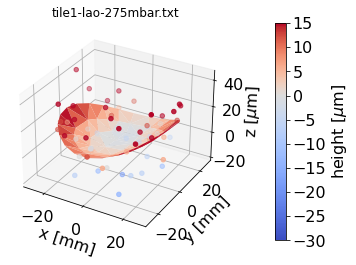

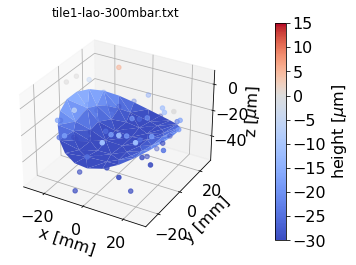

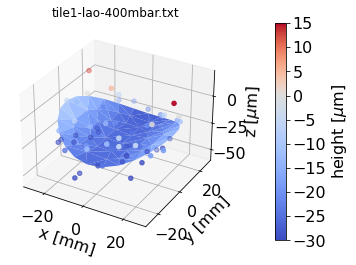

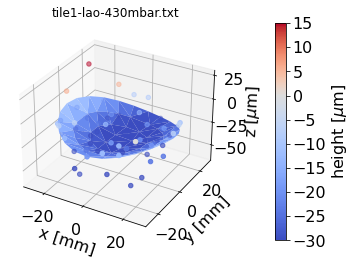

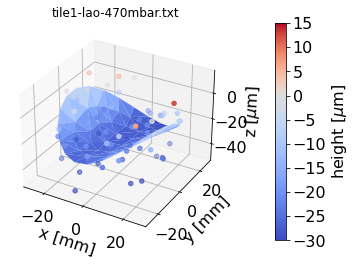

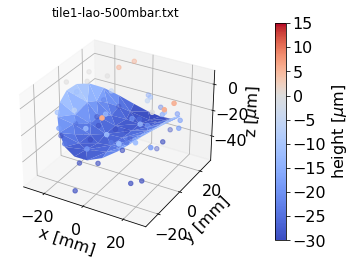

In [8]:
import tiling_disk_plots as tdp
dict_quad_minimizer = {}
dict_z_minmax = {}
for key,val in pt_data.items(): 
    X,Y,Z,dz = tdu.data_to_numpy(val)
    cost_fun = optim.get_quad_cost_fun(X,Y,Z,dz)
    m = Minuit(cost_fun, a=0, b=0,c=0,d=0,e=0, z_0=0.018)
    m.migrad()
    dict_quad_minimizer[key] = m
    Z = optim.quadratic_model(X,Y, *m.values)
    fig, ax = tdp.fit_surface_plot(X, Y, Z, show_data=True, data=val)
    ax.set_title(key)
    
    

# New Vac comparissent

## More granular Vac - Different Day

In [2]:
folder = 'Vac_Test'
meas_files = tdu.read_txt_files(folder, old=True)
Lao_NoVac_raw_data = meas_files['06102021_tile1-lao-0mbar.txt']
Lao_Vac_raw_data = meas_files['06102021_tile1-lao-60mbar.txt']

In [7]:
Lao_NoVac_pt = tdu.point_table(Lao_NoVac_raw_data)
Lao_NoVac_pt = tdu.add_meas_error_wrapper(Lao_NoVac_raw_data, Lao_NoVac_pt, n_hexagons=1)

In [8]:
from collections import OrderedDict

various_vac_lao_raw = {key.split('.')[0].split('_')[1].split('-')[2]: value for key, value in meas_files.items() if key.startswith('05102021')}
various_vac_lao_raw = OrderedDict(various_vac_lao_raw)
various_vac_lao_raw['60mbar'] = Lao_Vac_raw_data
various_vac_lao_raw.move_to_end('60mbar', last=False)
various_vac_lao_pt = {key: tdu.point_table(value) for key, value in various_vac_lao_raw.items()}

In [23]:
various_vac_lao_raw.keys()

odict_keys(['60mbar', '225mbar', '125mbar', '275mbar', '175mbar', '250mbar', '150mbar'])

In [9]:
various_lao_vac_novac = {}
for raw, pt in zip(various_vac_lao_raw.items(), various_vac_lao_pt.items()):
    # print(raw[1])
    data_container = tdu.add_meas_error_wrapper(raw[1], pt[1])
    various_lao_vac_novac[raw[0]] = data_container

In [10]:
all_lao_vac_novac_pt = {key: tdu.combine_mean_measurements(data, Lao_NoVac_pt) for key, data in various_lao_vac_novac.items()}

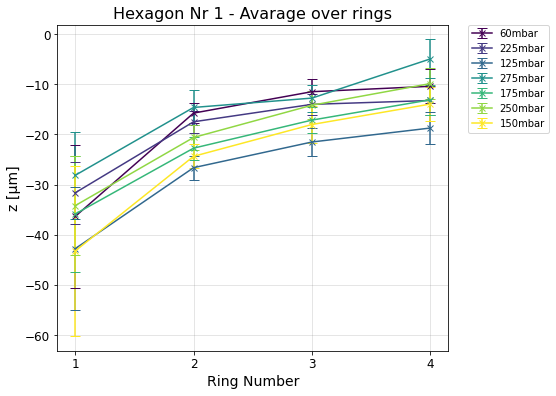

In [11]:
from scipy.stats import median_abs_deviation as mad  
from matplotlib.pyplot import cm 

color = cm.viridis(np.linspace(0, 1, len(all_lao_vac_novac_pt.keys())))

fig, ax = plt.subplots(1,1, figsize=(7,6))
ax.set_title(f'Hexagon Nr 1 - Avarage over rings', fontsize=16)
ax.set_xlabel('Ring Number', fontsize=14)
ax.set_ylabel('z [µm]', fontsize=14)
for measurement, c in zip(all_lao_vac_novac_pt.items(), color):
    vacuum, data = measurement
    ring_data = {f'data_r{num+1}': data.query(f'point in {ring}') for num, ring in enumerate(rings)}
    # modes = ['median', 'error_std', 'error_median_abs_deviation']
    rings_estimates = []
    rings_errors = []
    for ring_nr in range(1,5,1):
        data_plot = ring_data[f'data_r{ring_nr}']
         
        data_test = ring_data[f'data_r{ring_nr}']['z', 'mean'].to_numpy()
        ring_median = np.mean(ring_data[f'data_r{ring_nr}']['z', 'mean'].to_numpy())
        ring_mad = np.std(data_test) / np.sqrt(len(data_test))
        # ring_mad = np.mean(ring_data[f'data_r{ring_nr}']['z', 'std'].to_numpy() / (ring_data[f'data_r{ring_nr}']['z', 'std'].to_numpy()))
        rings_estimates.append(ring_median*1e3)
        rings_errors.append(ring_mad*1e3)

    ax.errorbar(list(range(1,5,1)), rings_estimates, yerr=rings_errors, marker='x', label=vacuum, capsize=5, c=c)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)
ax.tick_params(labelsize=12)
ax.set_xticks(range(1,5,1))


# Steel Vac Test


### import data

In [2]:
steel_folder = "steel_verformung"
steel_vac_dfs = tdu.read_txt_files(steel_folder)
steel_vac_dfs.keys()

dict_keys(['20211116_steel_400mbar.txt', '20211116_steel_350mbar.txt', '20211116_steel_450mbar.txt', '20211116_steel_150mbar.txt', '20211116_steel_250mbar.txt', '20211116_steel_60mbar.txt', '20211116_steel_300mbar.txt', '20211116_steel_1000mbar.txt', '20211116_steel_200mbar.txt', '20211116_steel_100mbar.txt'])

In [3]:
 #* clean run 2 from data, was not intended
steel_vac_dfs["20211116_steel_1000mbar.txt"] = steel_vac_dfs["20211116_steel_1000mbar.txt"].query("run_nr==1")

### create pivot table of data

In [4]:
steel_data_raw = {key.split('.')[0].split('_')[2]: val for key,val in steel_vac_dfs.items()}
steel_data_pt = {key.split('.')[0].split('_')[2]: tdu.point_table(val) for key,val in steel_vac_dfs.items()}

Sort Dataframe by vacuum strength

In [5]:
sorted_steel_raw = {key:val for key, val in sorted(steel_data_raw.items(), key=lambda item: abs(float(tdu.key_sort_helper(item[0]))))}
sorted_steel_pt = {key:val for key, val in sorted(steel_data_pt.items(), key=lambda item: abs(float(tdu.key_sort_helper(item[0]))))}

In [6]:
sorted_steel_pt.keys()

dict_keys(['60mbar', '100mbar', '150mbar', '200mbar', '250mbar', '300mbar', '350mbar', '400mbar', '450mbar', '1000mbar'])

### median hists

In [7]:
# for key, val in steel_data.items():
#     data = val['z', 'mean']
#     _,bins = knuth_bin_width(data, return_bins=True)
#     _,label = tdp.hist_label_data(data)
#     tdp.simple_hist(data, ax=None, ylog=False, nbins=bins,
#             title=key, label=label)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     #plt.xlim(-0.1,0.05)

### Transform data

In [8]:
# measurement with error for vac cases
steel_data_with_err = {}
for raw, pt in zip(sorted_steel_raw.items(), sorted_steel_pt.items()):
    # print(raw[1]), raw = (key, df) raw[0] = key, raw[1] = df
    data_container = tdu.add_meas_error_wrapper(raw[1], pt[1])
    steel_data_with_err[raw[0]] = data_container

In [9]:
# measurement with error for no vac case
steel_1000mbar_pt = tdu.add_meas_error_wrapper(steel_data_raw["1000mbar"], steel_data_pt["1000mbar"], n_hexagons=1)
# combine both dicts
all_steel_pt = {key: tdu.combine_mean_measurements(data, steel_1000mbar_pt) for key, data in steel_data_with_err.items()}

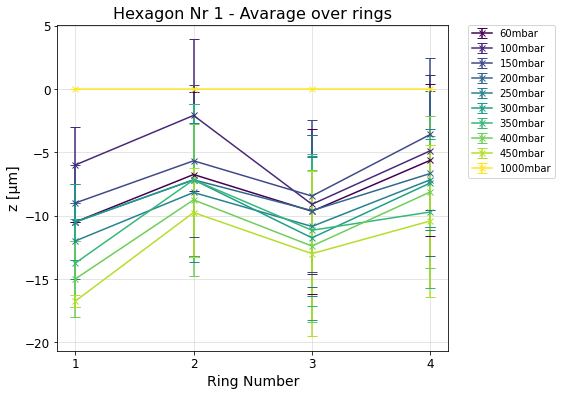

In [10]:
from scipy.stats import median_abs_deviation as mad  
from matplotlib.pyplot import cm 
from scipy.stats import median_abs_deviation

color = cm.viridis(np.linspace(0, 1, len(all_steel_pt.keys())))

fig, ax = plt.subplots(1,1, figsize=(7,6))
ax.set_title(f'Hexagon Nr 1 - Avarage over rings', fontsize=16)
ax.set_xlabel('Ring Number', fontsize=14)
ax.set_ylabel('z [µm]', fontsize=14)
for measurement, c in zip(all_steel_pt.items(), color):
    vacuum, data = measurement
    ring_data = {f'data_r{num+1}': data.query(f'point in {ring}') for num, ring in enumerate(rings)}
    # modes = ['median', 'error_std', 'error_median_abs_deviation']
    # print(ring_data['data_r2'])
    rings_estimates = []
    rings_errors = []
    for ring_nr in range(1,5,1):
        # print(ring_nr)
        data_plot = ring_data[f'data_r{ring_nr}']
        # print(data_plot)
        data_plot_z = data_plot['z', 'median'].to_numpy()
        # print(data_plot_z)
        ring_mean = np.mean(data_plot_z)
        ring_std = median_abs_deviation(data_plot_z)
        # print(f'ring nr {ring_nr}, n_points = {len(data_plot_z)}, std/sq(n)={ring_std*1e3}, std = {np.std(data_plot_z*1e3)}')
        # ring_mad = np.mean(ring_data[f'data_r{ring_nr}']['z', 'std'].to_numpy() / (ring_data[f'data_r{ring_nr}']['z', 'std'].to_numpy()))
        rings_estimates.append(ring_mean*1e3)
        rings_errors.append(ring_std*1e3)

    # print(f'ring_est = {rings_estimates[0]}, ring_err = {rings_errors[0]}')
    ax.errorbar(list(range(1,5,1)), rings_estimates, yerr=rings_errors, marker='x', label=vacuum, capsize=5, c=c)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)
ax.tick_params(labelsize=12)
ax.set_xticks(range(1,5,1))


todo: histogramme über die ringe erstellen um die verteilung anzugucken -> std ist größer geworden bei ring 4 -> sagt mir verteilung ist schlecht. mit median und mad sieht man einfach riesige errors -> man erkennt eine shape. ob sie richtig ist muss noch geklärt werden 

###  check distribution spatial

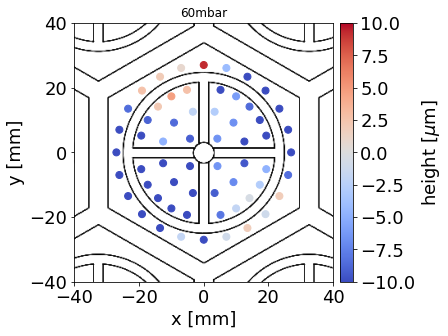

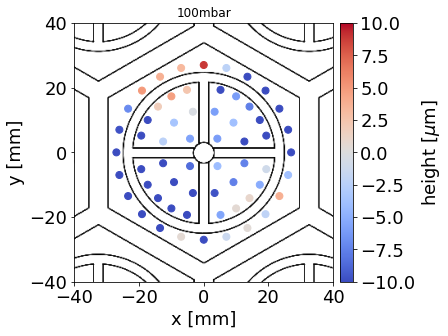

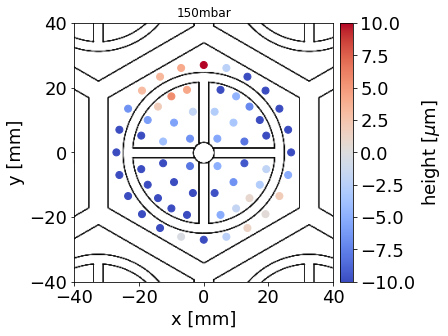

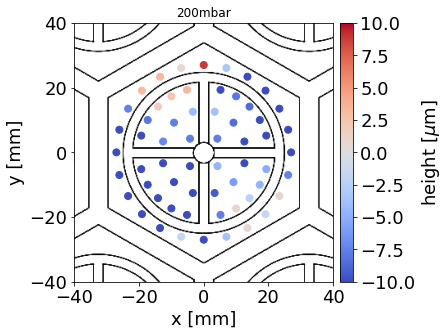

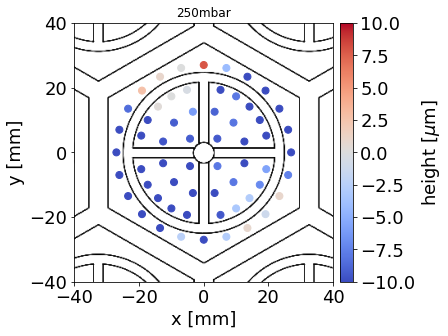

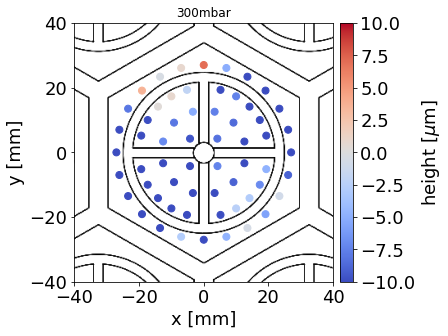

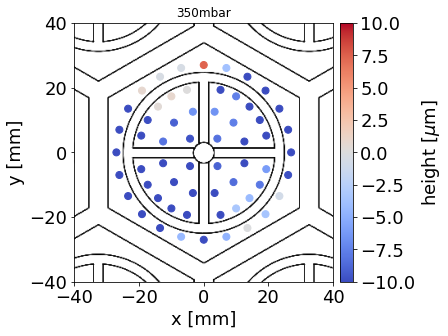

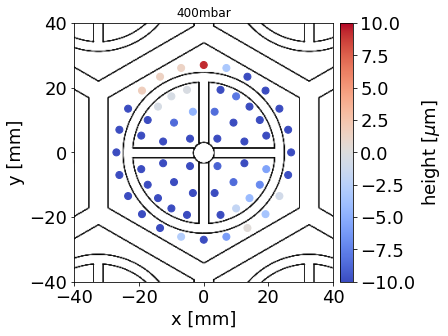

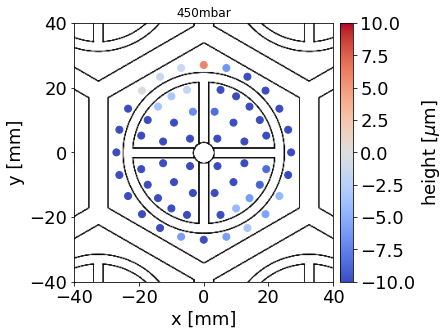

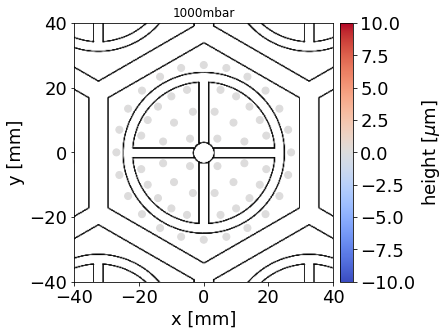

In [11]:
for vac, meas in all_steel_pt.items():
    fig, ax = tdp.full_hexagon_plot(meas, mode=('z', 'mean'), cmap='coolwarm', cbar_norm=(-10, 0, 10), size=7**2, figsize=(5,5))
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_title(vac)


In [12]:
steel_1000mbar_pt['z','median'].describe()

count     60.000000
mean    -157.224633
std        0.016672
min     -157.267000
25%     -157.231000
50%     -157.225000
75%     -157.212000
max     -157.182000
Name: (z, median), dtype: float64

In [13]:
steel_1000mbar_pt['z','median'].describe()

count     60.000000
mean    -157.224633
std        0.016672
min     -157.267000
25%     -157.231000
50%     -157.225000
75%     -157.212000
max     -157.182000
Name: (z, median), dtype: float64

In [14]:
max_ = 42.500000
min_ = -42.500000
mid_ = 0.500000
fig, ax = tdp.full_hexagon_plot(steel_1000mbar_pt_copy, mode=('z', 'median'), cmap='coolwarm', cbar_norm=(min_, mid_, max_), size=7**2, figsize=(5,5))
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.set_title(vac)


NameError: name 'steel_1000mbar_pt_copy' is not defined

### define quadrants

In [ ]:
qadrant_1 = [1,2,3,4,5,6,7,8,9,42,41,40,39,38]